# Modelling and Evaluation Notebook

## Objectives

*   Answer business requirement 2: 
    * The client is interested to tell whether a given cell contains a malaria parasite or not.


## Inputs

* inputs/malaria_dataset/cell_images/train
* inputs/malaria_dataset/cell_images/test
* inputs/malaria_dataset/cell_images/validation
* image shape embeddings.

## Outputs
* Images distribution plot in train, validation, and test set.
* Image augmentation.
* Class indices to change prediction inference in labels.
* Machine learning model creation and training.
* Save model.
* Learning curve plot for model performance.
* Model evaluation on pickle file.
* Prediction on the random image file.




## Additional Comments | Insights | Conclusions




---

---

# Import regular packages

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

---

# Set Working Directory

In [142]:
cwd= os.getcwd()

In [143]:
os.chdir('../Malaria-Detector/')
print("You set a new current directory")

You set a new current directory


In [144]:

work_dir = os.getcwd()
work_dir

'/Users/danielhamilton/Malaria-Detector'

---

## Set input directories

Set train, validation and test paths

In [145]:
my_data_dir = '../danielhamilton/Malaria-Detector/inputs/malaria_dataset/cell_images'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

## Set output directory

In [146]:
print(work_dir)
version = 'v1'
file_path = f'{work_dir}/outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)


/Users/danielhamilton/Malaria-Detector
Old version is already available create a new version.


## Set labels

In [147]:

labels = os.listdir(train_path)

print(
    f"Project Labels: {labels}"
)


Project Labels: ['Parasitized', 'Uninfected']


## Set image shape

In [148]:
## Import saved image shape embedding
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"{work_dir}/outputs/{version}/image_shape.pkl")
image_shape

(129, 129, 3)

---

# Number of images in train, test and validation data

* train - Parasitized: 3950 images
* train - Uninfected: 3950 images
* validation - Parasitized: 564 images
* validation - Uninfected: 564 images
* test - Parasitized: 1129 images
* test - Uninfected: 1129 images
          Set        Label  Frequency
0       train  Parasitized       3950
1       train   Uninfected       3950
2  validation  Parasitized        564
3  validation   Uninfected        564
4        test  Parasitized       1129
5        test   Uninfected       1129




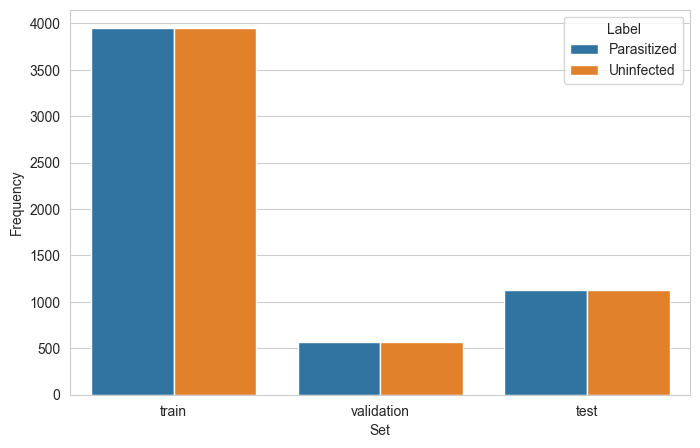

In [149]:
# df_freq = pd.DataFrame([])
df_freq = pd.DataFrame(columns=['Set', 'Label', 'Frequency'])
for folder in ['train', 'validation', 'test']:
    for label in labels:
        # df_freqNew = pd.Series(data={'Set': [folder],
        #                     'Label': [label],
        #                     'Frequency': int(len(os.listdir(my_data_dir + '/' + folder + '/' + label)))}
        #               )
        # pd.concat([df_freq,df_freqNew], ignore_index=True)
        freq = int(len(os.listdir(my_data_dir + '/' + folder + '/' + label)))
        df_freq.loc[len(df_freq)] = [folder, label, freq]
        print(
            f"* {folder} - {label}: {len(os.listdir(my_data_dir+'/'+ folder + '/' + label))} images")
print(df_freq)

print("\n")
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png',
            bbox_inches='tight', dpi=150)
plt.show()


---

# Image data augmentation

---

### ImageDataGenerator

In [150]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

* ### Initialize ImageDataGenerator

In [151]:
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )


* ### Augment training image dataset

In [152]:
batch_size = 20  # Set batch size
train_set = augmented_image_data.flow_from_directory(train_path,
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='binary',
                                                     shuffle=True
                                                     )

train_set.class_indices


Found 7900 images belonging to 2 classes.


{'Parasitized': 0, 'Uninfected': 1}

* ### Augment validation image dataset

In [153]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='binary',
                                                                        shuffle=False
                                                                        )

validation_set.class_indices


Found 1128 images belonging to 2 classes.


{'Parasitized': 0, 'Uninfected': 1}

* ### Augment test image dataset

In [154]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='binary',
                                                                  shuffle=False
                                                                  )

test_set.class_indices


Found 2258 images belonging to 2 classes.


{'Parasitized': 0, 'Uninfected': 1}

## Plot augmented training image

(20, 129, 129, 3)


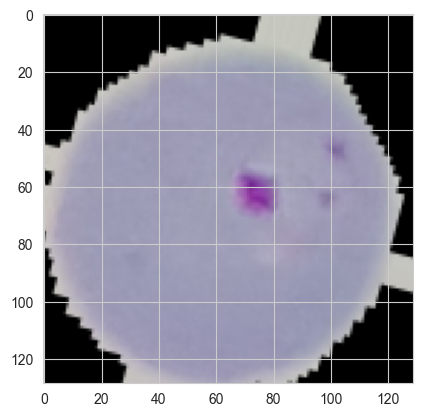

(20, 129, 129, 3)


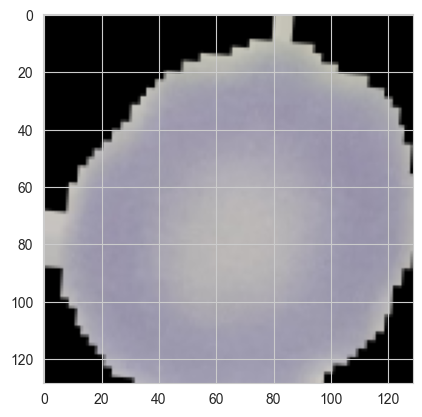

(20, 129, 129, 3)


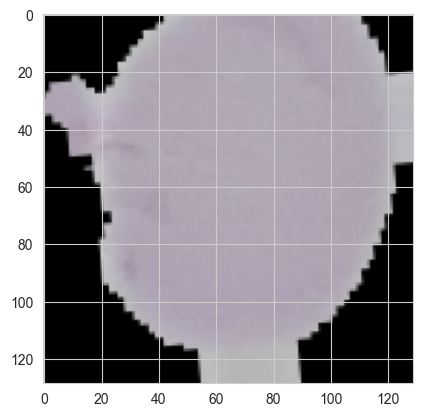

In [155]:
for _ in range(3):
    img, label = train_set.next()
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()


## Plot augmented validation and test images

(20, 129, 129, 3)


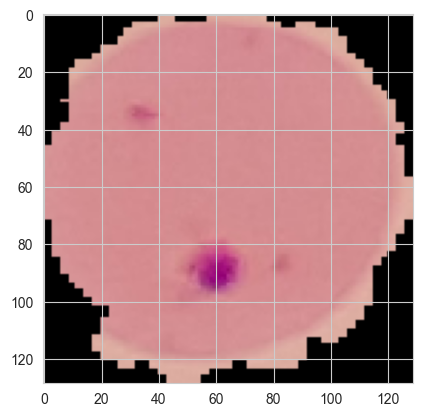

(20, 129, 129, 3)


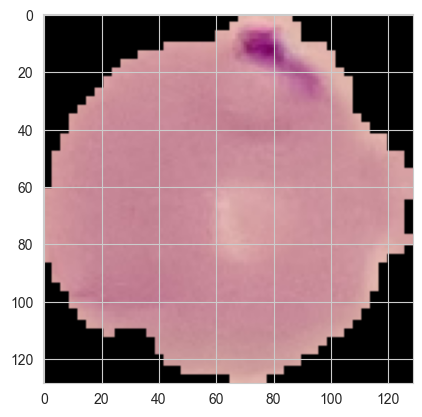

(20, 129, 129, 3)


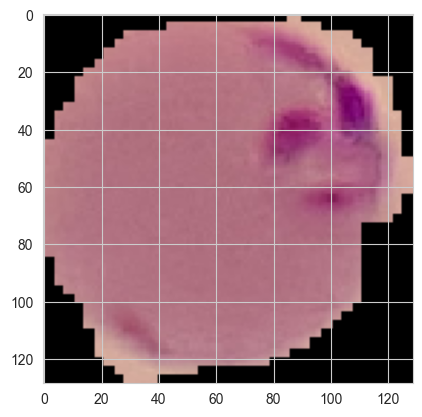

In [156]:
for _ in range(3):
    img, label = validation_set.next()
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()


(20, 129, 129, 3)


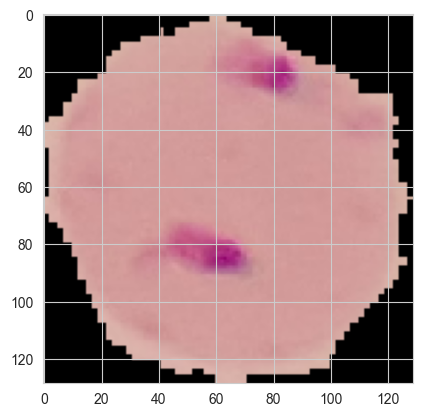

(20, 129, 129, 3)


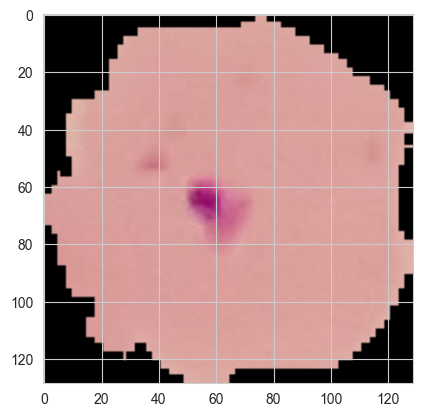

(20, 129, 129, 3)


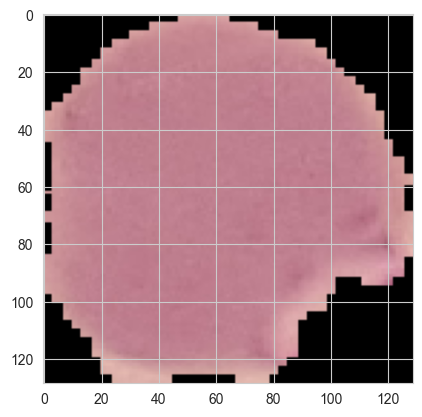

In [157]:
for _ in range(3):
    img, label = test_set.next()
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()


## Save class_indices

In [158]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")


['/Users/danielhamilton/Malaria-Detector/outputs/v1/class_indices.pkl']

---

# Model creation

---

## ML model

* ### Import model packages

In [159]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

* ### Model 

In [160]:

def create_tf_model():
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))

    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model


* ### Model Summary 

In [161]:
create_tf_model().summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 127, 127, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 30, 30, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 14, 14, 64)      

* ### Early Stopping 

In [162]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3)


## Fit model for model training

In [163]:
model = create_tf_model()
model.fit(train_set,
          epochs=25,
          steps_per_epoch=len(train_set.classes) // batch_size,
          validation_data=validation_set,
          callbacks=[early_stop],
          verbose=1
          )


Epoch 1/25


2023-05-11 22:59:59.364187: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


395/395 [==============================] - ETA: 0s - loss: 0.5350 - accuracy: 0.7371

2023-05-11 23:01:08.665225: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


395/395 [==============================] - 72s 177ms/step - loss: 0.5350 - accuracy: 0.7371 - val_loss: 0.2586 - val_accuracy: 0.9379
Epoch 2/25
395/395 [==============================] - 68s 172ms/step - loss: 0.3234 - accuracy: 0.9014 - val_loss: 0.1839 - val_accuracy: 0.9415
Epoch 3/25
395/395 [==============================] - 69s 175ms/step - loss: 0.2285 - accuracy: 0.9372 - val_loss: 0.1314 - val_accuracy: 0.9637
Epoch 4/25
395/395 [==============================] - 72s 183ms/step - loss: 0.1775 - accuracy: 0.9494 - val_loss: 0.1151 - val_accuracy: 0.9672
Epoch 5/25
395/395 [==============================] - 74s 188ms/step - loss: 0.1609 - accuracy: 0.9556 - val_loss: 0.1151 - val_accuracy: 0.9628
Epoch 6/25
395/395 [==============================] - 77s 196ms/step - loss: 0.1647 - accuracy: 0.9539 - val_loss: 0.1101 - val_accuracy: 0.9672
Epoch 7/25
395/395 [==============================] - 77s 194ms/step - loss: 0.1500 - accuracy: 0.9586 - val_loss: 0.1355 - val_accuracy: 0.9

## Save model

In [164]:
model.save('outputs/v1/malaria_detector_model.h5')

In [165]:
model.save('outputs/v1/malaria_detector_modeal.h5')

---

# Model Performace

---

## Model learning curve

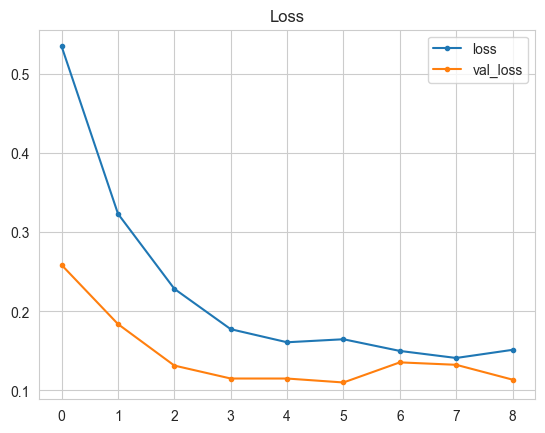

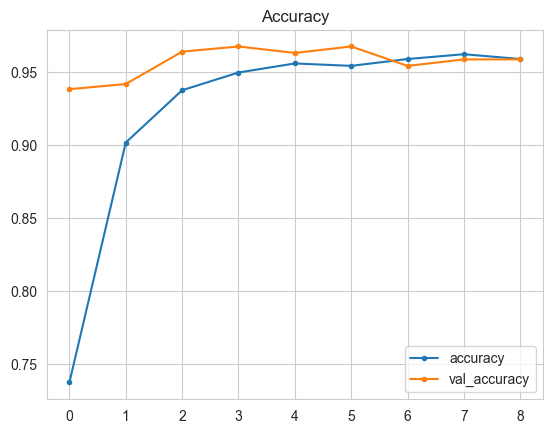

In [166]:
losses = pd.DataFrame(model.history.history)

sns.set_style("whitegrid")
losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png',
            bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png',
            bbox_inches='tight', dpi=150)
plt.show()


## Model Evaluation

Load saved model

In [167]:
from keras.models import load_model
model = load_model('outputs/v1/malaria_detector_model.h5')

Evaluate model on test set

In [168]:
evaluation = model.evaluate(test_set)


2023-05-11 23:11:09.913433: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


113/113 [==============================] - 6s 49ms/step - loss: 0.1164 - accuracy: 0.9601


### Save evaluation pickle

In [169]:
joblib.dump(value=evaluation,
            filename=f"outputs/v1/evaluation.pkl")


['outputs/v1/evaluation.pkl']

## Predict on new data

Load a random image as PIL

Image shape: (129, 129), Image mode: RGB


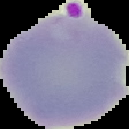

In [170]:
from tensorflow.keras.preprocessing import image

pointer = 64
label = labels[0]  # select Uninfected or Parasitised

pil_image = image.load_img(test_path + '/' + label + '/' + os.listdir(test_path+'/' + label)[pointer],
                           target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image


Convert image to array and prepare for prediction

In [171]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/255
print(my_image.shape)

(1, 129, 129, 3)


Predict class probabilities

In [172]:
pred_proba = model.predict(my_image)[0, 0]

target_map = {v: k for k, v in train_set.class_indices.items()}
pred_class = target_map[pred_proba > 0.5]

if pred_class == target_map[0]:
    pred_proba = 1 - pred_proba

print(pred_proba)
print(pred_class)


1/1 [==============================] - 0s 137ms/step
0.9883286980912089
Parasitized


---

# Push files to Repo

## Push generated/new files from this Session to your GitHub repo

* .gitignore

In [173]:
!cat .gitignore

259522.47s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


inputs/malaria_dataset/cell_images/test
inputs/malaria_dataset/cell_images/train
kaggle.json
*.ipynb
__pycache__/



* Git status

In [174]:
!git status

259527.68s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   jupyter_notebooks/03 - Modelling and Evaluating.ipynb

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	outputs/v1/class_indices.pkl
	outputs/v1/evaluation.pkl
	outputs/v1/labels_distribution.png
	outputs/v1/malaria_detector_modeal.h5
	outputs/v1/malaria_detector_model.h5
	outputs/v1/model_training_acc.png
	outputs/v1/model_training_losses.png

no changes added to commit (use "git add" and/or "git commit -a")


* Git add

In [175]:
!git add .

259532.93s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


* Git commit

In [176]:
!git commit -am " Add new plots"

259539.04s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


[main ad4b0477]  Add new plots
 8 files changed, 114 insertions(+), 25 deletions(-)
 create mode 100644 outputs/v1/class_indices.pkl
 create mode 100644 outputs/v1/evaluation.pkl
 create mode 100644 outputs/v1/labels_distribution.png
 create mode 100644 outputs/v1/malaria_detector_modeal.h5
 create mode 100644 outputs/v1/malaria_detector_model.h5
 create mode 100644 outputs/v1/model_training_acc.png
 create mode 100644 outputs/v1/model_training_losses.png


* Git Push

In [177]:
!git push

259544.31s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Enumerating objects: 17, done.
Counting objects: 100% (17/17), done.
Delta compression using up to 16 threads
Compressing objects: 100% (9/9), done.
Writing objects: 100% (12/12), 17.05 MiB | 9.97 MiB/s, done.
Total 12 (delta 3), reused 1 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/dlhamilton/Malaria-Detector.git
   f0fbccf7..ad4b0477  main -> main


---